In [26]:
import sys
sys.path.append('../')

import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

import numpy as np
import pandas as pd
import os
import glob
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

eps = np.finfo(float).eps

plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

from data import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
ds = SimpleSine()
loader = DataLoader(ds, batch_size=16, shuffle=True)

xc, yc = loader.__iter__().__next__()

batch_sz, num_points = xc.size(0), xc.size(1)
context_data = torch.cat((xc, yc), -1).view(batch_sz * num_points, -1)


In [37]:
context_data.size()

torch.Size([1600, 2])

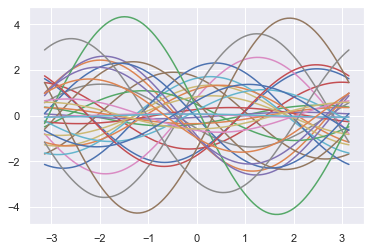

In [35]:
sns.set()
x, _ = ds[0]
for index in range(32):
    _, y = ds[index]
    plt.plot(x, y)

In [73]:
class NP1D(nn.Module):
    def __init__(self, x_dim=1, y_dim=1, h_dim=16, r_dim=32, z_dim=32):
        super(NP1D, self).__init__()
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.h_dim = h_dim
        self.g_dim = h_dim
        self.r_dim = r_dim
        self.z_dim = z_dim

        
        self.encoder = nn.Sequential(
            nn.Linear(self.x_dim + self.y_dim, self.h_dim),
            nn.ReLU(inplace=True),
            nn.Linear(self.h_dim, self.h_dim),
            nn.ReLU(inplace=True),
            nn.Linear(self.h_dim, self.r_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.z_dim + self.x_dim, self.g_dim),
            nn.ReLU(inplace=True),
            nn.Linear(self.g_dim, self.g_dim),
            nn.ReLU(inplace=True),
            nn.Linear(self.g_dim, self.y_dim)
        )
        
        self.mu_layer = nn.Linear(self.r_dim, self.z_dim)
        self.logvar_layer = nn.Linear(self.r_dim, self.z_dim)
        
    def sample(self, batch_sz, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(mu)
        return z

        pass
    
    def encode(self, xy):
        return self.encoder(xy)
    
    def decode(self, xz):
        return self.decoder(xz)
    
    def forward(self, xc, yc, xt=None, yt=None):
        batch_sz, num_points = xc.size(0), xc.size(1)
        context_data = torch.cat((xc, yc), -1).view(batch_sz * num_points, -1)
    
        if self.training:
            target_data = torch.cat((xc, yc), -1).view(batch_sz * num_points, -1)
            
            r_context = self.encode(context_data).view(batch_sz, num_points, self.r_dim)
            r_target = self.encode(target_data).view(batch_sz, num_points, self.r_dim)
            r_all = torch.cat((r_context, r_target), dim=0)
            r_avg = torch.mean(r_all, dim=1).view(batch_sz, -1)
        else:
            r_context = self.encode(context_data).view(batch_sz, num_points, self.r_dim)
            r_avg = torch.mean(r_context, dim=1).view(batch_sz, -1)
            
        mu = self.mu_layer(r_avg) # (num_points x z_dim)
        log_var = self.logvar_layer(r_avg) # (num_points x z_dim)

        z = self.sample(batch_sz, mu, log_var)
        z = z.unsqueeze(1).repeat(1, num_points, 1)
        print("z {}".format(z.size()))
        print("xt {}".format(xt.size()))
        targetz_data = torch.cat((z, xt), -1)
        yt_hat = self.decode(targetz_data)
        return yt_hat

In [65]:
ds = SimpleSine()
loader = DataLoader(ds, batch_size=16, shuffle=True)

In [74]:
x, y = loader.__iter__().__next__()

xc, yc = x[:8], y[:8]
xt, yt = x[8:], y[8:]

model = NP1D()
model.eval()

yt_hat = model(xc, yc, xt, None)

z torch.Size([8, 100, 32])
xt torch.Size([8, 100, 1])


In [75]:
yt_hat.size()

torch.Size([8, 100, 1])

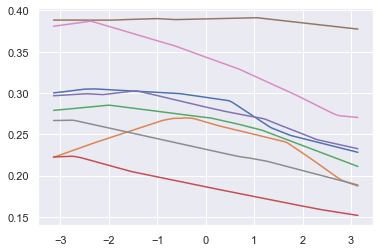

In [76]:
sns.set()
x, _ = ds[0]
for index in range(8):
    y = yt_hat[index].detach().numpy()
    plt.plot(x, y)